<a href="https://colab.research.google.com/github/Nedu21/Keras-deep-learning-projects/blob/main/Image_Classifier_Model_With_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classifier Model With CNN**
Practice goals of this model
- Data preprocessing
- Model building
- Callbacks (Early stopping & Learning rate scheduling)
- Overfitting control (Dropout, Batch normalization & Data augmentation)

## Make necessary imports

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Input, Activation, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt

## Model preprocessing

### Set seed value

In [ ]:
seed = 42

In [ ]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Split the training data into training and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size = 0.2,
    stratify = y_train, # 👈 this preserves class distribution
    random_state = seed
)

# Print shapes
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 690s 4us/step
(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


### Convert the target variable into binary categories using keras to_categorical function



In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

### Set number of classes for model output

In [ ]:
num_classes = y_train.shape[1]

### Perform data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255.0)
test_datagen = ImageDataGenerator(rescale=1./255.0)

# Load images
train_generator = train_datagen.flow(x_train, y_train, batch_size=32, shuffle=True, seed=seed)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32, shuffle=False, seed=seed)
test_generator = test_datagen.flow(x_test, y_test, shuffle=False, seed=seed)

### Plot image samples

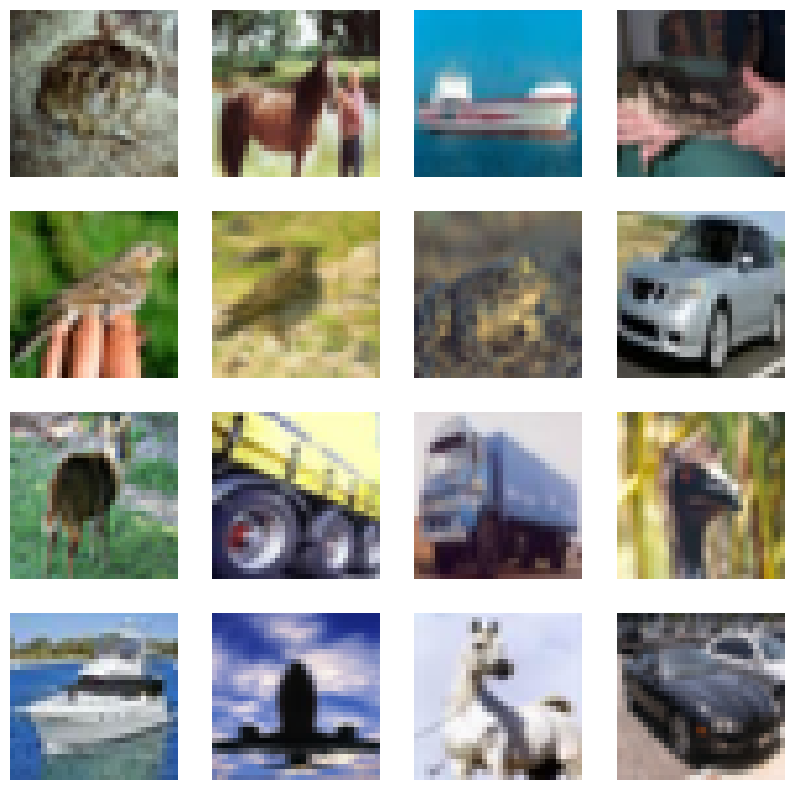

In [37]:
# Display a sample of the training images
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.show()

## Build & Train the model
BatchNorm works best when used:

- Right after a linear transformation (like Conv or Dense)

- And before the activation function

In [ ]:
input_layer = Input(shape=(32, 32, 3))

# First convolutional layer
x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# Second convolutional layer
x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# Third convolutional layer
x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# Consider GlobalAveragePooling2D instead of Flatten
# Using Flatten() can result in many parameters — which can overfit easily. You can try GlobalAveragePooling2D instead.
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
# Dense layers are fully connected, meaning every neuron connects to every input.They have far more weights than Conv layers.
# This makes them more prone to overfitting the training data.
# So we drop random neurons to force the model to learn robust representations.
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(input_layer, output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

### Train the model with early stopping and learning rate scheduling

In [9]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss', # Quantity to be monitored
    factor = 0.5, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience = 5, # Number of epochs with no improvement after which learning rate will be reduced
    min_lr = 1e-6, # Lower bound on the learning rate
)

# Early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss', # Quantity to be monitored
    patience = 10, # Number of epochs with no improvement after which training will be stopped
    restore_best_weights = True, # Whether to restore model weights from the epoch with the best value of the monitored quantity
    start_from_epoch = 5 # Number of epochs to wait before starting to monitor improvement
)

history = model.fit(
    train_generator,
    epochs = 100,
    validation_data = val_generator,
    callbacks = [lr_scheduler, early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 112ms/step - accuracy: 0.3000 - loss: 1.9049 - val_accuracy: 0.4152 - val_loss: 1.6548 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.4413 - loss: 1.5387 - val_accuracy: 0.4481 - val_loss: 1.5225 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 114ms/step - accuracy: 0.4948 - loss: 1.3973 - val_accuracy: 0.3105 - val_loss: 2.7828 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.5172 - loss: 1.3265 - val_accuracy: 0.4878 - val_loss: 1.4247 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 111ms/step - accuracy: 0.5427 - loss: 1.2806 - val_accuracy: 0.4269 - val_loss: 2.0134 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 115ms/step - accuracy: 0.5664 - loss: 1.2315 - val_accuracy: 0.4425 - val_loss: 1.7430 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 145s 116ms/step

In [10]:
# 1. See what epoch it stopped on (if you still have the callback object)
print("Stopped epoch (0-indexed):", early_stopping.stopped_epoch)
print("Stopped epoch (1-indexed):", early_stopping.stopped_epoch + 1)

# 2. See which epoch had the best val_loss (from history)
best_epoch = np.argmin(history.history['val_loss']) + 1
print("Best epoch (by val_loss):", best_epoch)

# 3. Evaluate the restored best model on test set
test_loss, test_acc = model.evaluate(test_generator)
print("Test loss:", test_loss, "Test accuracy:", test_acc)


Stopped epoch (0-indexed): 61
Stopped epoch (1-indexed): 62
Best epoch (by val_loss): 52
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7946 - loss: 0.5954
Test loss: 0.594171404838562 Test accuracy: 0.7982000112533569


### Plot train/val loss, acc and LR to understand what happened

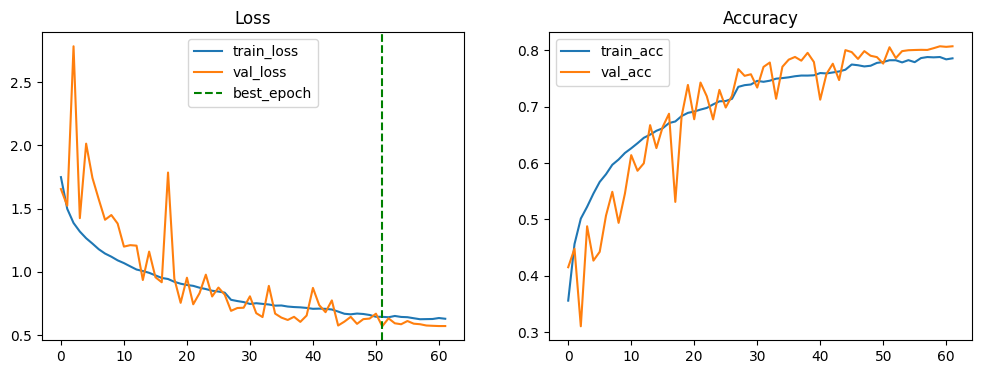

In [20]:
hist = history.history

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.axvline(best_epoch-1, color='green', linestyle='--', label='best_epoch')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(hist['accuracy'], label='train_acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()


### Plot confusion matrix(AI generated code)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


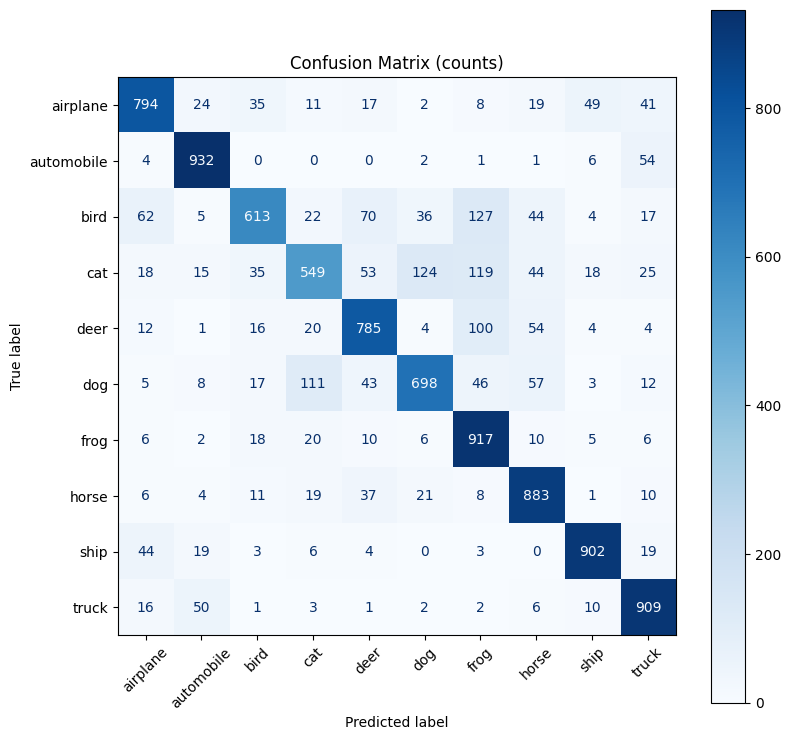

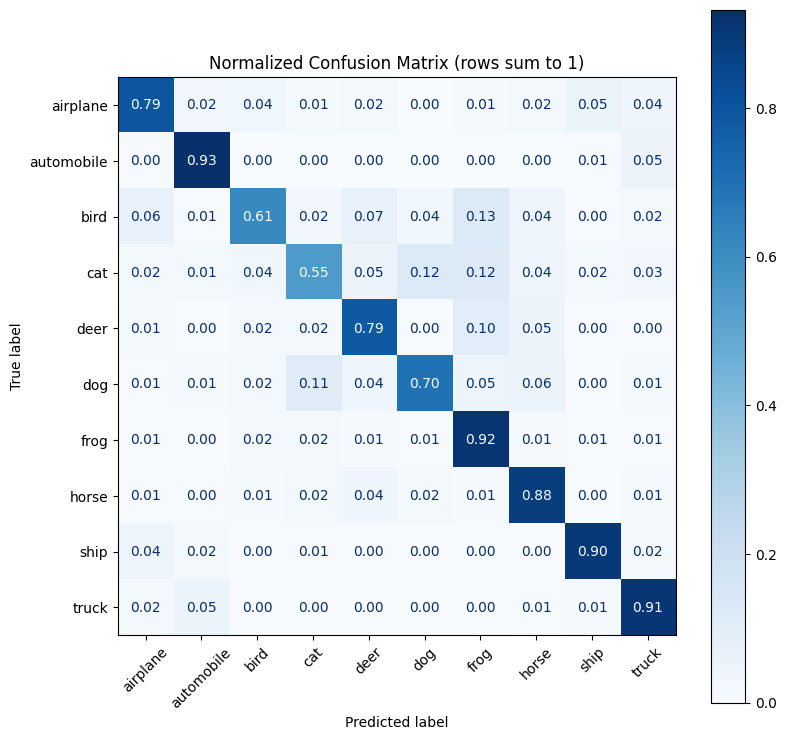

In [15]:
# CIFAR-10 class names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Make sure generator yields from the start and not shuffled
# (important: test_generator must have been created with shuffle=False)
test_generator.reset()

# 1) Get model predictions (probabilities) on the whole test set
y_prob = model.predict(test_generator, verbose=1)          # returns (N, num_classes)
y_pred = np.argmax(y_prob, axis=1)                         # predicted class indices

# 2) Obtain true labels in a robust way
if hasattr(test_generator, 'classes'):                     # flow_from_directory sets .classes
    y_true = np.array(test_generator.classes)
elif hasattr(test_generator, 'y'):                          # ImageDataGenerator.flow stores .y
    # .y may be one-hot or integer labels
    if test_generator.y.ndim == 1:
        y_true = np.array(test_generator.y)
    else:
        y_true = np.argmax(test_generator.y, axis=1)
else:
    # Fallback: try to use y_test variable (common when using cifar10.load_data())
    try:
        # y_test could be one-hot or integer labels
        y_true = np.array(y_test)
        if y_true.ndim > 1:
            y_true = np.argmax(y_true, axis=1)
    except NameError:
        raise RuntimeError(
            "Can't find true labels. Ensure your test generator exposes labels "
            "(test_generator.classes or test_generator.y) or that `y_test` exists."
        )

# 3) Confusion matrix (absolute counts)
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(9,9))
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix (counts)')
plt.xticks(rotation=45)
plt.show()

# 4) Normalized confusion matrix (per-row / per-class)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(9,9))
disp_norm = ConfusionMatrixDisplay(cm_norm, display_labels=class_names)
disp_norm.plot(ax=ax, cmap='Blues', values_format='.2f')
plt.title('Normalized Confusion Matrix (rows sum to 1)')
plt.xticks(rotation=45)
plt.show()

### Show some misclassified examples

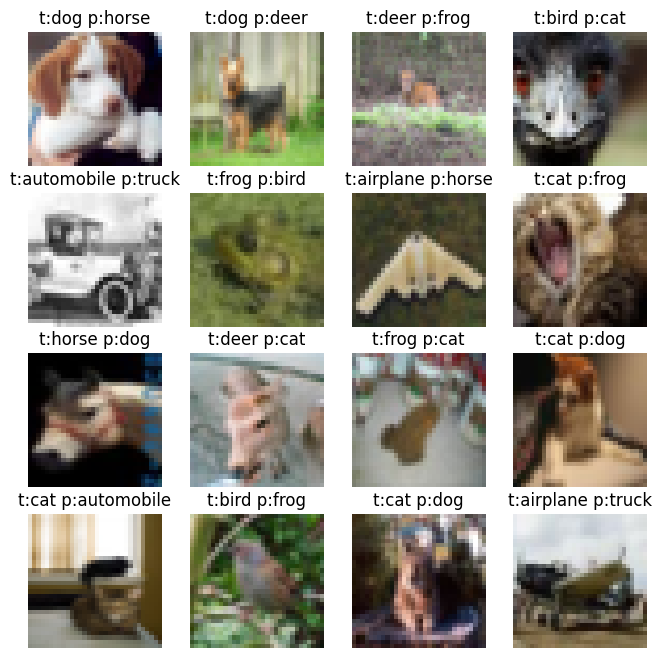

In [35]:
mis_idx = np.where(y_true != y_pred)[0]
plt.figure(figsize=(8, 8))
for j, i in enumerate(mis_idx[:16]): # Take up to 16 misclassified examples
    plt.subplot(4, 4, j+1) # Use a separate counter 'j' for subplot index
    img, true, pred = x_test[i], class_names[y_true[i]], class_names[y_pred[i]]
    plt.imshow(img)
    plt.title(f"t:{true} p:{pred}")
    plt.axis('off')
plt.show()